<a href="https://colab.research.google.com/github/BillWang04/CSE151A-Group-Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r requirements.txt

  Using cached numpy-1.24.4-cp38-cp38-macosx_11_0_arm64.whl.metadata (5.6 kB)
  Using cached pandas-2.0.3-cp38-cp38-macosx_11_0_arm64.whl.metadata (18 kB)
  Using cached scikit_learn-1.3.2-cp38-cp38-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached matplotlib-3.7.5-cp38-cp38-macosx_11_0_arm64.whl.metadata (5.7 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached plotly-5.20.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl.metadata (2.0 kB)
  Using cached lightgbm-4.3.0.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Ignored the following versions that require a different python version: 0.45.0 Requires-Python >=3.9; 1.25.0 Requires-Python >=3.9; 1.25.0rc1 Requires-Python >=3.9; 1.25.1 Requires-Python >=3.9; 1.25.2 Requires-Python >=3.9; 1.26.0 Requires-P

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
business = pd.read_csv('data/business.csv')
economy = pd.read_csv('data/economy.csv')

In [4]:
def clean(df, class_):
    def extract_stops(description):
        stops_match = re.search(r'(\d+)-?stop', description)
        if stops_match:
            return int(stops_match.group(1))
        else:
            return 0
    def duration_to_hours(duration):
        hours, minutes = duration.split('h ')
        hours = float(hours.strip()) if len(hours.strip()) > 1 else 0
        minutes = int(minutes[:-1].strip()) if len(minutes.strip()) > 1 else 0
        total_hours = hours + minutes / 60
        return round(total_hours, 3)
    df_copy = df.copy()
    df_copy["price"] = df_copy["price"].str.replace("," , "").astype(int)
    df_copy["flight_code"] = df_copy["ch_code"].astype(str).str.cat(df_copy["num_code"].astype(str), sep="_")
    df_copy['num_stops'] = df_copy['stop'].apply(extract_stops)
    df_copy["time_taken"] = df_copy["time_taken"].apply(duration_to_hours)
    df_copy['date'] = pd.to_datetime(df_copy['date'], format="%d-%m-%Y")
    df_copy['day_of_week'] = df_copy['date'].dt.dayofweek
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['arr_time'] = pd.to_datetime(df_copy['arr_time'])
    df_copy['arr_time'] = df_copy['arr_time'].dt.hour + (df_copy['arr_time'].dt.minute >= 30)
    df_copy['dep_time'] = pd.to_datetime(df_copy['dep_time'])
    df_copy['dep_time'] = df_copy['dep_time'].dt.hour + (df_copy['dep_time'].dt.minute >= 30)
    df_copy = df_copy.drop(columns= ["date", "ch_code", "num_code", "stop"])
    df_copy["class"] = class_
    df_copy = df_copy[["airline", "flight_code", "class", "from", "to", "time_taken", "dep_time", "arr_time", "num_stops", "month", "day_of_week", "price"]]
    return df_copy



In [5]:
cleaned_df = pd.concat([clean(economy, "economy"), clean(business, "business")])
cleaned_df

/var/folders/75/4b4y2mlx2yv_34rkxb83ydkr0000gn/T/ipykernel_50545/2232736731.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_copy['arr_time'] = pd.to_datetime(df_copy['arr_time'])
/var/folders/75/4b4y2mlx2yv_34rkxb83ydkr0000gn/T/ipykernel_50545/2232736731.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_copy['dep_time'] = pd.to_datetime(df_copy['dep_time'])
/var/folders/75/4b4y2mlx2yv_34rkxb83ydkr0000gn/T/ipykernel_50545/2232736731.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_copy['arr_time'] = pd.to_datetime(df_copy['arr_time'])
/var/folders/75/4b4

,airline,flight_code,class,from,to,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
0,SpiceJet,SG_8709,economy,Delhi,Mumbai,2.167,19,21,0,2,4,5953
1,SpiceJet,SG_8157,economy,Delhi,Mumbai,2.333,6,9,0,2,4,5953
2,AirAsia,I5_764,economy,Delhi,Mumbai,2.167,4,7,0,2,4,5956
3,Vistara,UK_995,economy,Delhi,Mumbai,2.250,10,13,0,2,4,5955
4,Vistara,UK_963,economy,Delhi,Mumbai,2.333,9,11,0,2,4,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
93482,Vistara,UK_822,business,Chennai,Hyderabad,10.083,10,20,1,3,3,69265
93483,Vistara,UK_826,business,Chennai,Hyderabad,10.417,13,23,1,3,3,77105
93484,Vistara,UK_832,business,Chennai,Hyderabad,13.833,7,21,1,3,3,79099
93485,Vistara,UK_828,business,Chennai,Hyderabad,10.000,7,17,1,3,3,81585


In [6]:
cleaned_df.describe()

,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
count,300261.000000,300261.000000,300261.00000,300261.000000,300261.000000,300261.000000,300261.000000
mean,12.217291,13.509850,15.80090,0.835703,2.664995,2.954656,20883.717666
std,7.193560,5.412152,6.05027,0.370546,0.471993,2.003251,22695.911266
min,0.333000,0.000000,0.00000,0.000000,2.000000,0.000000,1105.000000
25%,6.750000,9.000000,11.00000,1.000000,2.000000,1.000000,4783.000000
50%,11.250000,13.000000,17.00000,1.000000,3.000000,3.000000,7425.000000
75%,16.167000,19.000000,21.00000,1.000000,3.000000,5.000000,42521.000000
max,49.833000,24.000000,24.00000,1.000000,3.000000,6.000000,123071.000000


Let's first visualize the number of flights by Airline within our dataset.

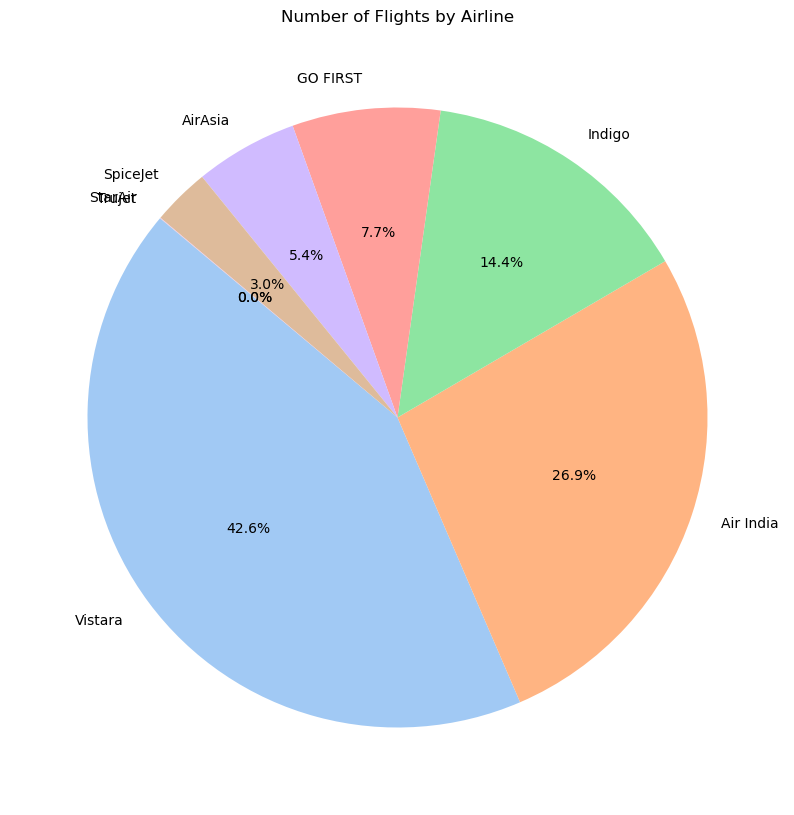

In [7]:
plt.figure(figsize=(10, 15))
airline_counts = cleaned_df['airline'].value_counts()
plt.pie(airline_counts, labels=airline_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Number of Flights by Airline')
plt.show()

In [8]:
cleaned_df['airline'].value_counts()

airline
Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23177
AirAsia       16098
SpiceJet       9011
StarAir          61
Trujet           41
Name: count, dtype: int64

It looks like Vistara has by far the most flight data, making up almost half of our dataset, while Trujet and StarAir have very little data (less than 1% of our dataset).

Is there variation in flight prices depending on the day of the week?

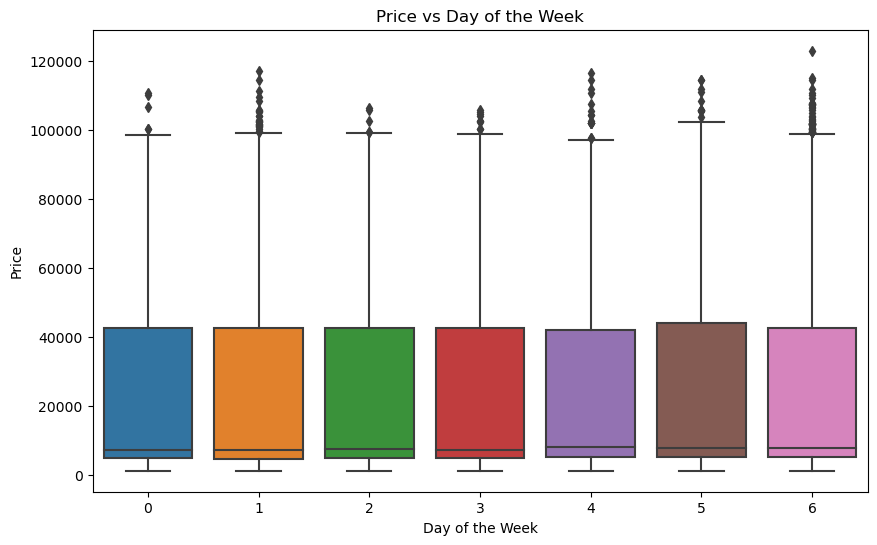

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='price', data=cleaned_df)
plt.title('Price vs Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Price')
plt.show()

It looks like flight prices are generally relatively stable regardless of the day of the week, with similar distributions for each day. However, this does not take into account differences in pricing between different airlines. If we look at a specific airline, Vistara, does this change?

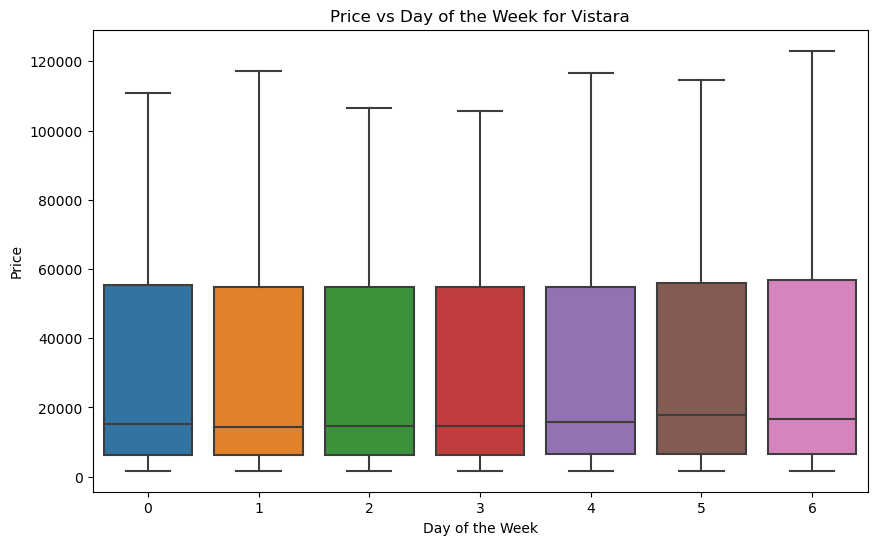

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='price', data=cleaned_df[cleaned_df['airline'] == 'Vistara'])
plt.title('Price vs Day of the Week for Vistara')
plt.xlabel('Day of the Week')
plt.ylabel('Price')
plt.show()

We can see more clearly that the median prices are relatively stable, with the most expensive flights being toward the weekend rather than in the middle of the week. Compared to the combined data for all airlines, we see that the median price for each day is significantly higher (closer to 20000), which indicates that Vistara has generally more expensive flights than other airlines.

We can take a look at the distribution of prices by airline.

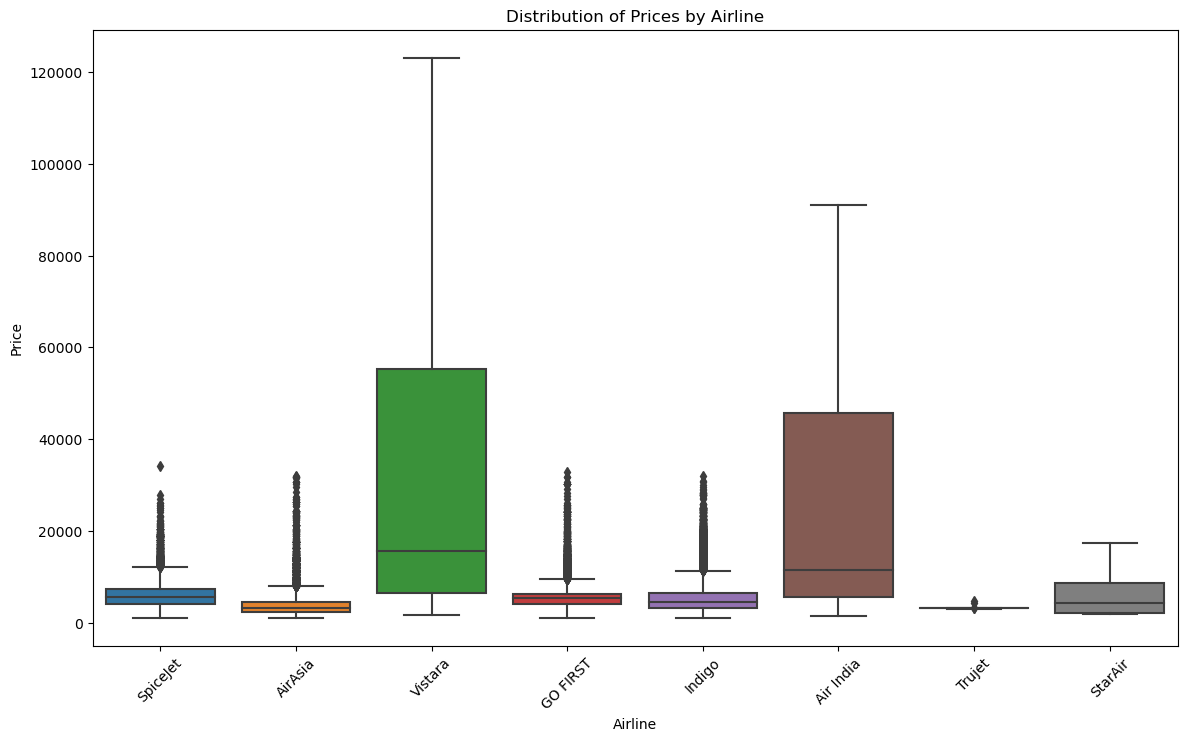

In [11]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='airline', y='price', data=cleaned_df)
plt.title('Distribution of Prices by Airline')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

Here, we can see that Vistara and Air India have the most expensive flights, with a larger range of flight prices. For all airlines, the median price is below 20000.

In [12]:
cleaned_df['month'].value_counts()

month
3    199672
2    100589
Name: count, dtype: int64

It looks like all of our flight data comes from either February or March, and there is more data on flights from March and February.

Let's see if there are any patterns with departure time and pricing.

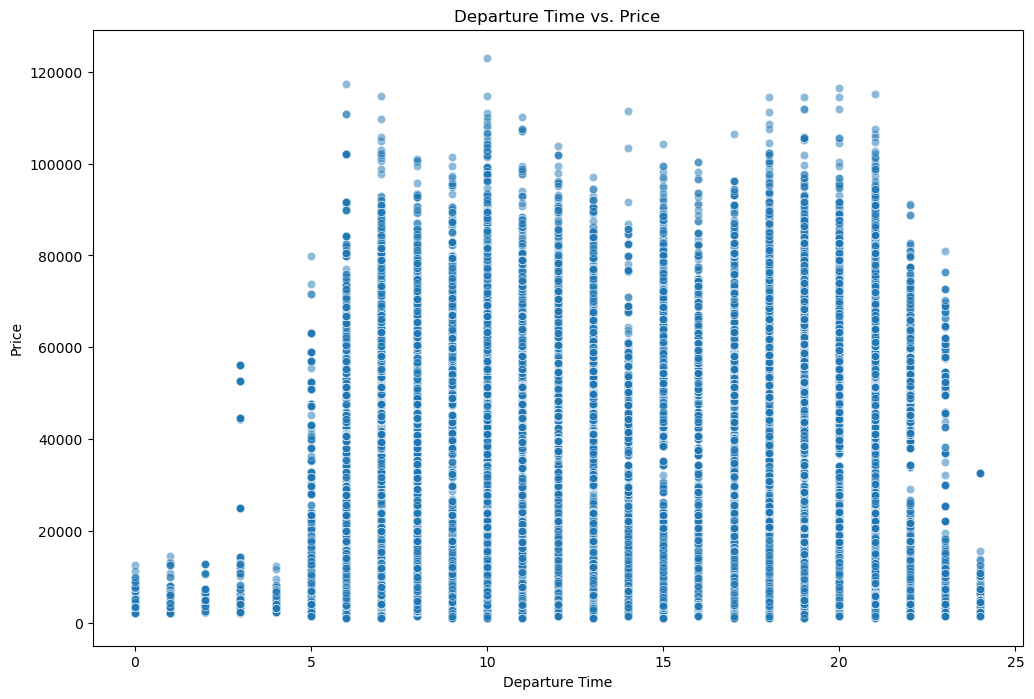

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='dep_time', y='price', data=cleaned_df, alpha=0.5)
plt.title('Departure Time vs. Price')
plt.xlabel('Departure Time')
plt.ylabel('Price')
plt.show()

We can see that flights the depart between around 11pm-5am are significantly rarer and cheaper than other departure times.

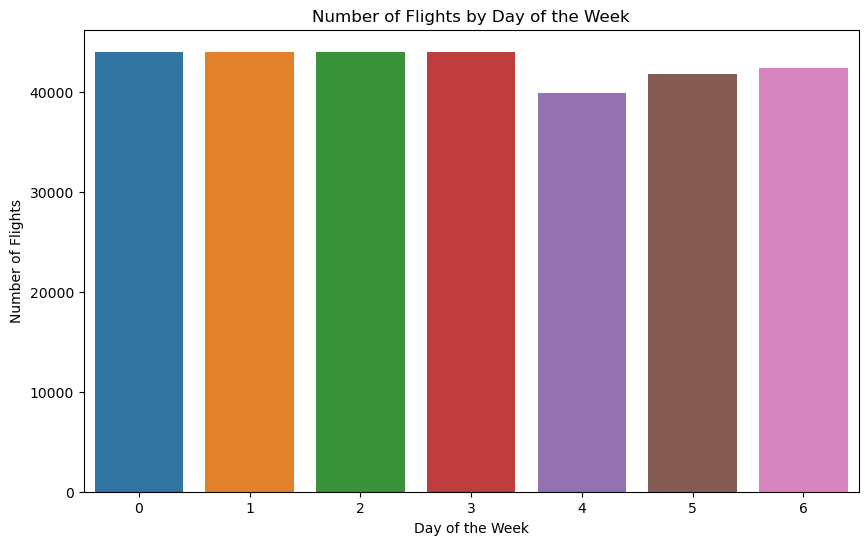

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=cleaned_df)
plt.title('Number of Flights by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Flights')
plt.show()

Given this bar chart, it seems that we have around the same amount of flight data for every day of the week.

### PairPlot and Correlation Matrix

In [15]:
cleaned_df.dtypes

airline         object
flight_code     object
class           object
from            object
to              object
time_taken     float64
dep_time         int32
arr_time         int32
num_stops        int64
month            int32
day_of_week      int32
price            int64
dtype: object

<Axes: >

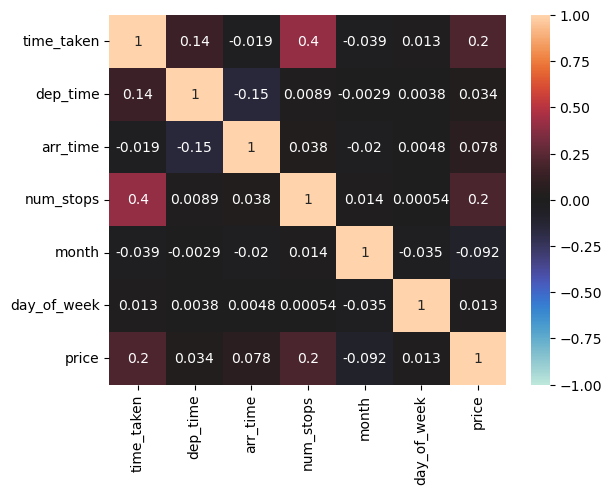

In [16]:
# drop the qualitative data
quantidata = cleaned_df.drop(columns = ['airline','flight_code','class','from','to'])

corr = quantidata.corr()
sns.heatmap(corr, annot = True, vmin=-1,vmax=1,center=0)

/Users/walterwong/anaconda3/envs/dsc80/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


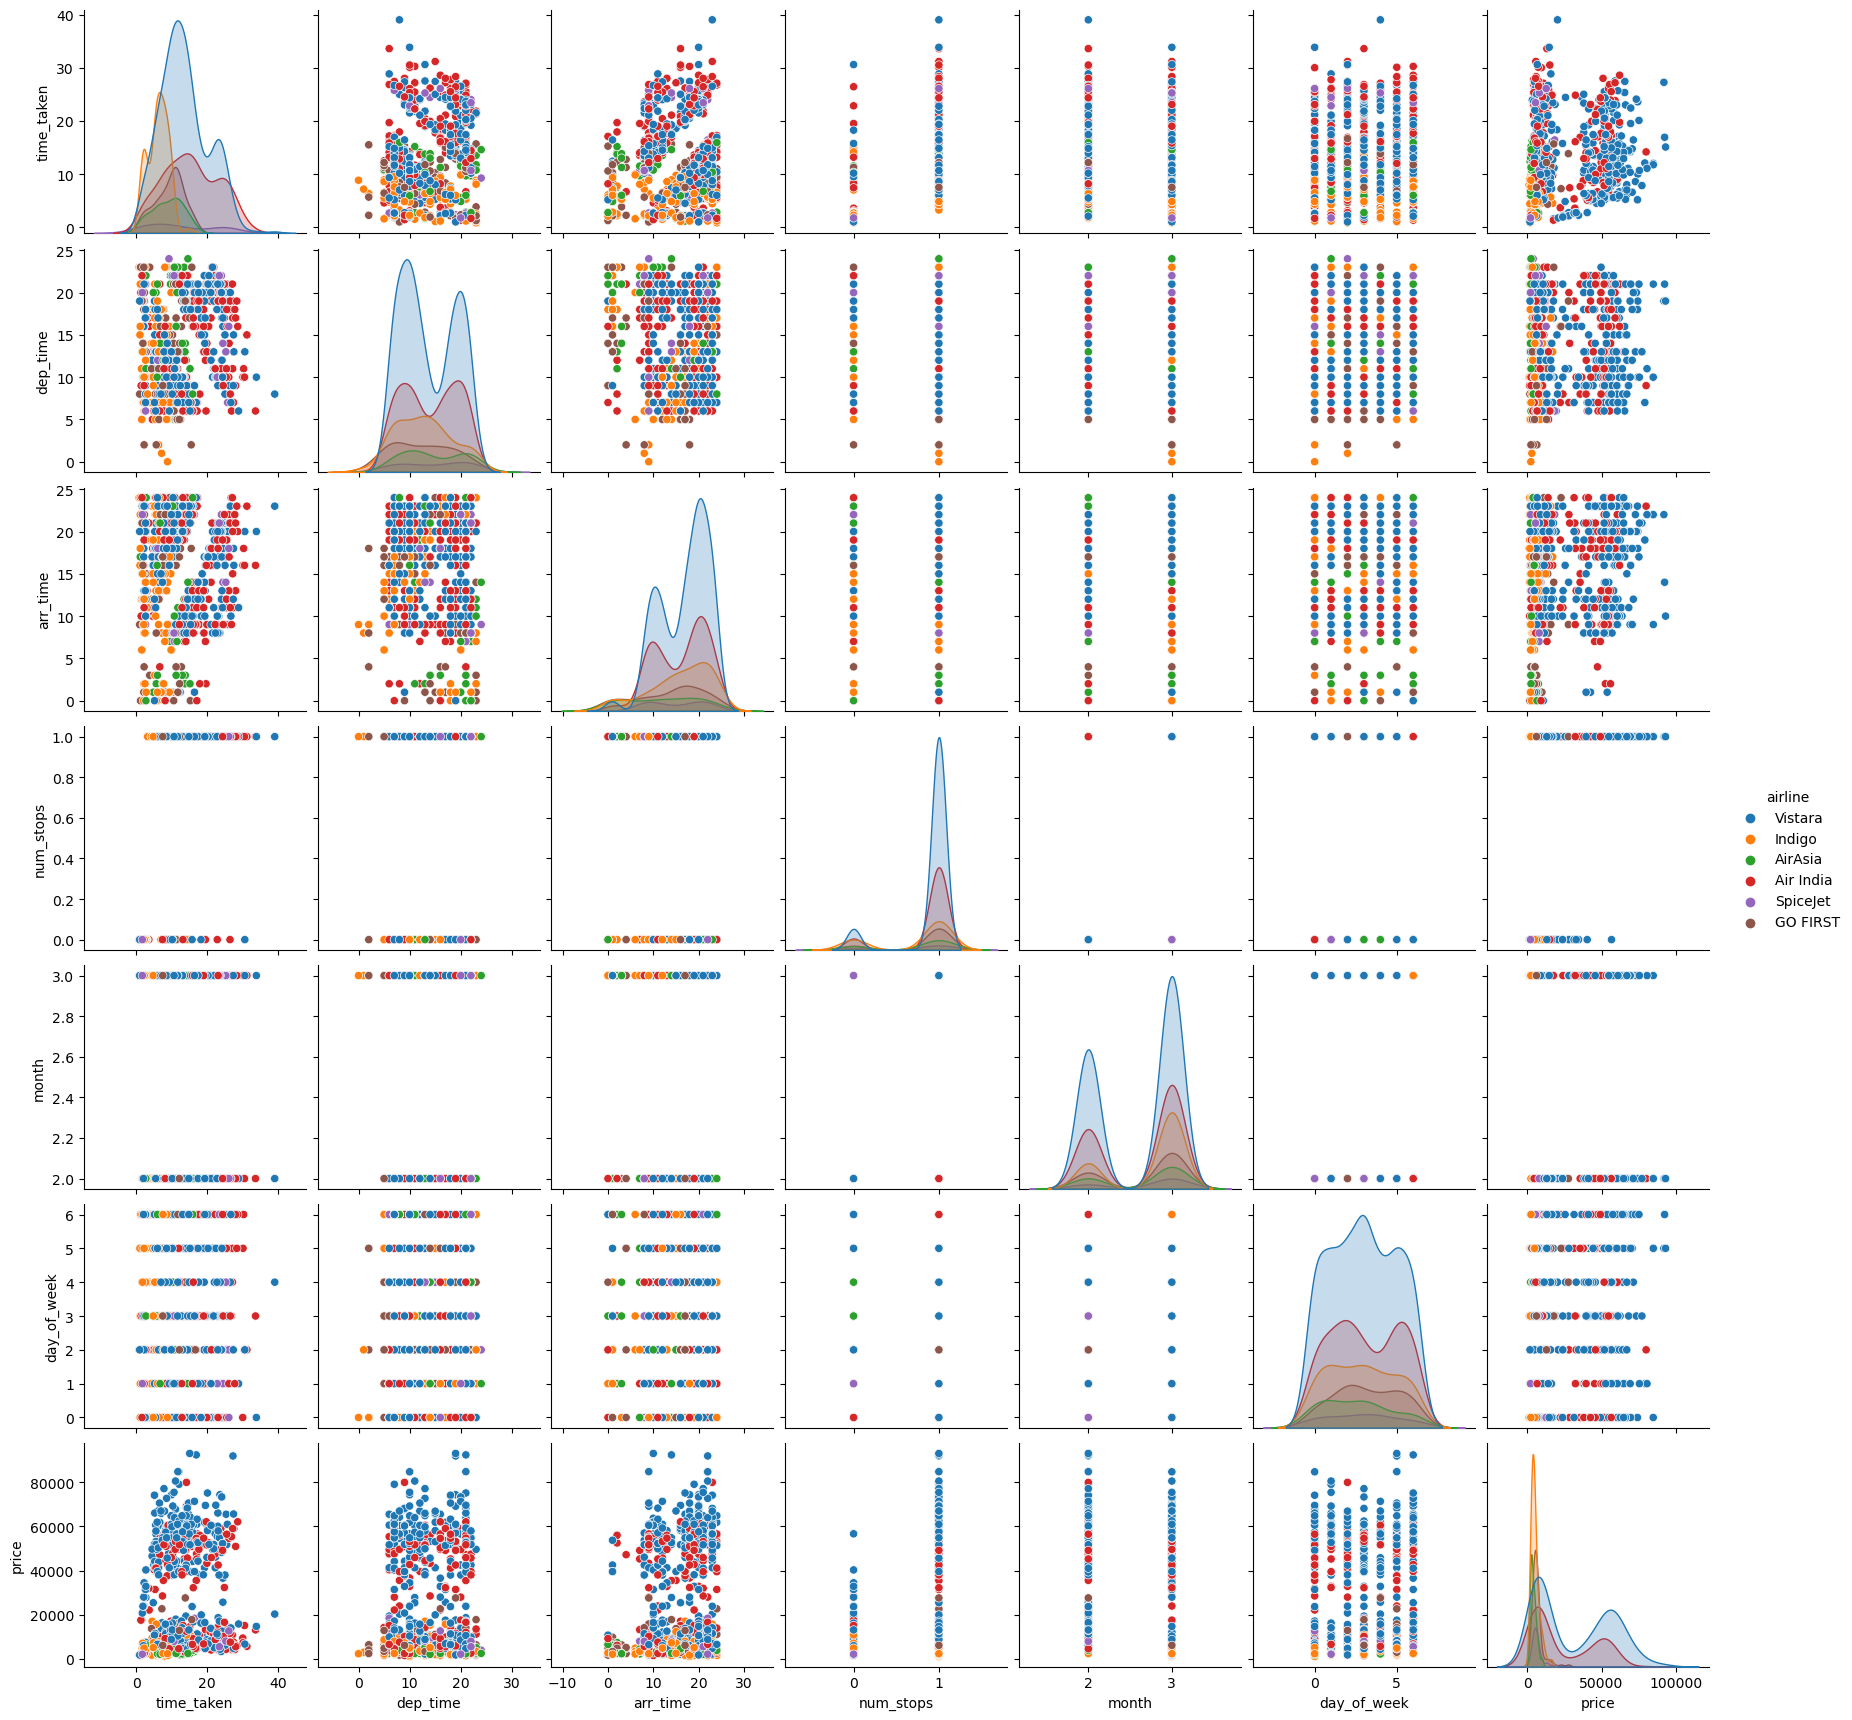

In [17]:
num_samples = 1000
sampled_df = cleaned_df.sample(n=num_samples,random_state=42)
sns.pairplot(sampled_df, hue="airline")

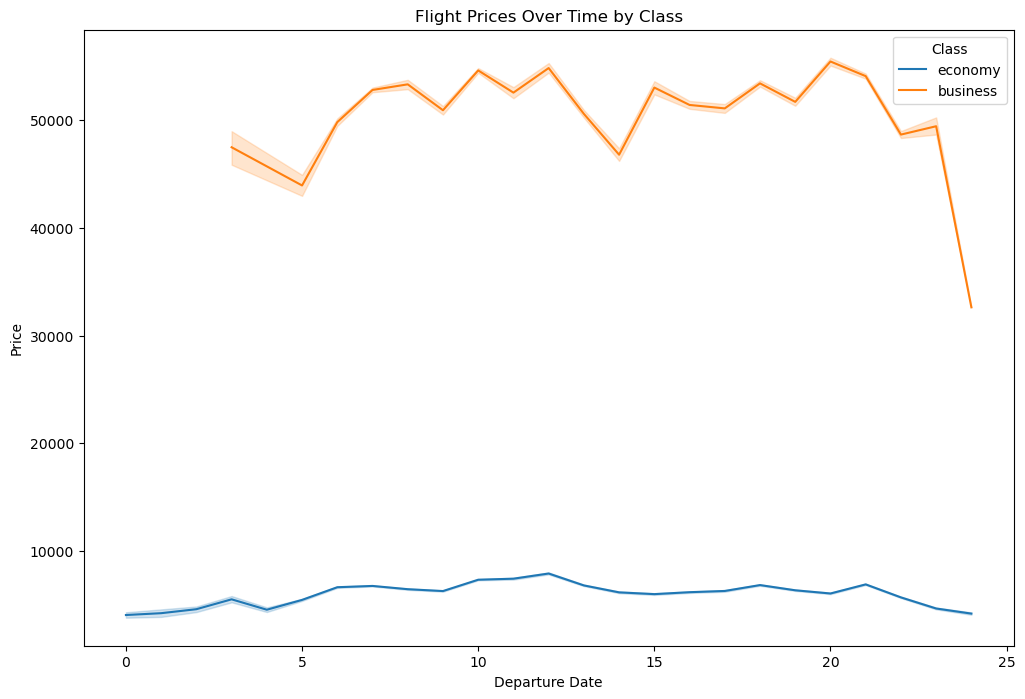

In [18]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=cleaned_df, x='dep_time', y='price', hue='class')

plt.title('Flight Prices Over Time by Class')
plt.xlabel('Departure Date')
plt.ylabel('Price')
plt.legend(title='Class')

# **Preprocess the data**

In [19]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# quantidata = df with only numerical categories
#One Hot Encode (Y)
oneHot = OneHotEncoder()
oneHot_classes = oneHot.fit_transform(cleaned_df.airline.values.reshape(-1,1)).toarray()
y = oneHot_classes

#Normalize the data
#classed_dropped = cleaned_df.drop(columns= ['class', 'airline', 'flight_code', 'from', 'to'])

norm_scaler = MinMaxScaler()
normalized_data = norm_scaler.fit_transform(quantidata)

#Standardize the data
stand_scaler = StandardScaler()
standardized_data = stand_scaler.fit_transform(quantidata)

In [20]:
oneHot_classes[1]

array([0., 0., 0., 0., 1., 0., 0., 0.])

In [21]:
pd.DataFrame(normalized_data)

,0,1,2,3,4,5,6
0,0.037051,0.791667,0.875000,0.0,0.0,0.666667,0.039749
1,0.040404,0.250000,0.375000,0.0,0.0,0.666667,0.039749
2,0.037051,0.166667,0.291667,0.0,0.0,0.666667,0.039773
3,0.038727,0.416667,0.541667,0.0,0.0,0.666667,0.039765
4,0.040404,0.375000,0.458333,0.0,0.0,0.666667,0.039765
...,...,...,...,...,...,...,...
300256,0.196970,0.416667,0.833333,1.0,1.0,0.500000,0.558844
300257,0.203717,0.541667,0.958333,1.0,1.0,0.500000,0.623124
300258,0.272727,0.291667,0.875000,1.0,1.0,0.500000,0.639473
300259,0.195293,0.291667,0.708333,1.0,1.0,0.500000,0.659856


In [22]:
quantidata

,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
0,2.167,19,21,0,2,4,5953
1,2.333,6,9,0,2,4,5953
2,2.167,4,7,0,2,4,5956
3,2.250,10,13,0,2,4,5955
4,2.333,9,11,0,2,4,5955
...,...,...,...,...,...,...,...
93482,10.083,10,20,1,3,3,69265
93483,10.417,13,23,1,3,3,77105
93484,13.833,7,21,1,3,3,79099
93485,10.000,7,17,1,3,3,81585


In [23]:
cleaned_df.airline.value_counts()

airline
Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23177
AirAsia       16098
SpiceJet       9011
StarAir          61
Trujet           41
Name: count, dtype: int64

<Axes: xlabel='time_taken', ylabel='Count'>

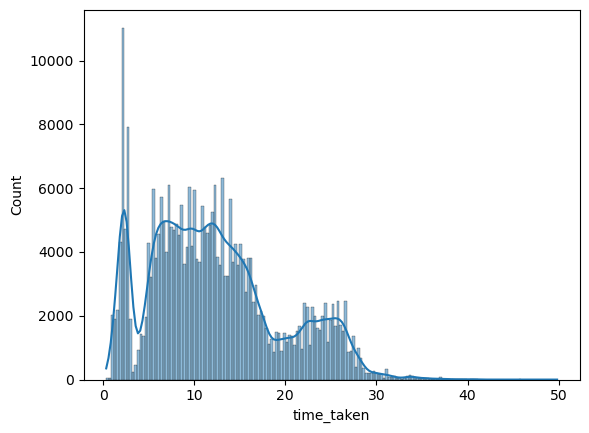

In [24]:
sns.histplot(cleaned_df['time_taken'], kde=True)

<Axes: xlabel='time_taken', ylabel='Count'>

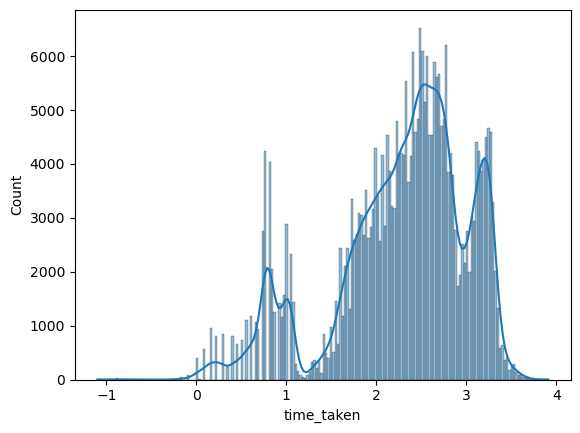

In [25]:
sns.histplot(cleaned_df['time_taken'].apply(np.log), kde=True)

In [26]:
cleaned_df[cleaned_df['airline'] == 'StarAir']

,airline,flight_code,class,from,to,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
109730,StarAir,S5_151,economy,Bangalore,Hyderabad,1.000,7,8,0,2,5,4337
109764,StarAir,S5_131,economy,Bangalore,Hyderabad,5.083,15,20,1,2,5,11382
110001,StarAir,S5_151,economy,Bangalore,Hyderabad,1.000,7,8,0,2,1,4337
110098,StarAir,S5_131,economy,Bangalore,Hyderabad,5.083,15,20,1,2,1,17482
110430,StarAir,S5_151,economy,Bangalore,Hyderabad,1.000,7,8,0,2,5,4337
...,...,...,...,...,...,...,...,...,...,...,...,...
169904,StarAir,S5_152,economy,Hyderabad,Bangalore,1.083,20,21,0,3,3,2115
169988,StarAir,S5_150,economy,Hyderabad,Bangalore,5.083,9,14,1,3,3,9582
170131,StarAir,S5_152,economy,Hyderabad,Bangalore,1.083,20,21,0,3,5,2115
170514,StarAir,S5_152,economy,Hyderabad,Bangalore,1.083,20,21,0,3,1,2115


In [27]:
cleaned_df.day_of_week.value_counts()

day_of_week
0    44073
1    44041
2    44023
3    44022
6    42399
5    41809
4    39894
Name: count, dtype: int64

In [28]:
cleaned_df

,airline,flight_code,class,from,to,time_taken,dep_time,arr_time,num_stops,month,day_of_week,price
0,SpiceJet,SG_8709,economy,Delhi,Mumbai,2.167,19,21,0,2,4,5953
1,SpiceJet,SG_8157,economy,Delhi,Mumbai,2.333,6,9,0,2,4,5953
2,AirAsia,I5_764,economy,Delhi,Mumbai,2.167,4,7,0,2,4,5956
3,Vistara,UK_995,economy,Delhi,Mumbai,2.250,10,13,0,2,4,5955
4,Vistara,UK_963,economy,Delhi,Mumbai,2.333,9,11,0,2,4,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
93482,Vistara,UK_822,business,Chennai,Hyderabad,10.083,10,20,1,3,3,69265
93483,Vistara,UK_826,business,Chennai,Hyderabad,10.417,13,23,1,3,3,77105
93484,Vistara,UK_832,business,Chennai,Hyderabad,13.833,7,21,1,3,3,79099
93485,Vistara,UK_828,business,Chennai,Hyderabad,10.000,7,17,1,3,3,81585


## Modeling

### Linear Regression

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

cleaned_df['weekend'] = cleaned_df['day_of_week'] > 4

X_train, X_test, y_train, y_test = train_test_split(cleaned_df.drop(columns=['price']), cleaned_df['price'], test_size=0.2, random_state=42)


prepoc = ColumnTransformer([
    ('airline', OneHotEncoder(handle_unknown='ignore'), ['airline', 'class']), #comment out for baseline
    ('log', FunctionTransformer(lambda x: np.log(x + 0.001)), ['time_taken']), # comment out for baseline
    # ('square', FunctionTransformer(lambda x: x**2), ['RES.PRICE']),
    ('test', FunctionTransformer(lambda x: x), ['dep_time', 'arr_time', 'num_stops', 'weekend']),
    # ('test', FunctionTransformer(lambda x: x), ['TOTAL.PRICE', 'OUTAGE.DURATION']), #baseline
], remainder='drop')

pipe = Pipeline([
        ('prepoc', prepoc),
        ('pog', LinearRegression())
    ])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# # Predict on the testing data
predictions = pipe.predict(X_test)



In [30]:
train_predictions = pipe.predict(X_train)

RMSE_test = np.sqrt(np.sum((y_test - predictions)**2) / y_test.shape[0])
RMSE_train = np.sqrt(np.sum((y_train - train_predictions)**2) / y_train.shape[0])
RMSE_train

7197.171314483312

In [31]:
RMSE_test

7225.820958308152

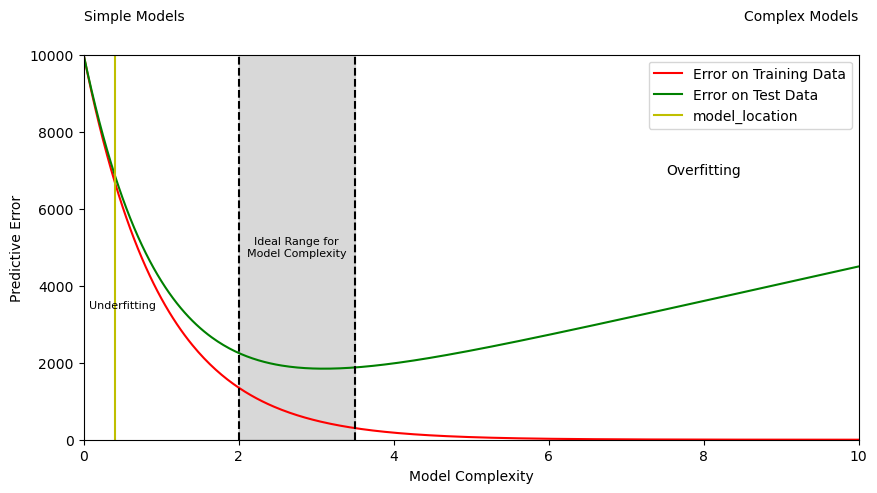

In [32]:
model_complexity = np.linspace(0, 10, 400)

training_error = 10000 * np.exp(-model_complexity) 
test_error = 10000 * np.exp(-model_complexity) + 4500 * (model_complexity / 10)

plt.figure(figsize=(10, 5))

plt.plot(model_complexity, training_error, 'r', label='Error on Training Data')
plt.plot(model_complexity, test_error, 'g', label='Error on Test Data')

plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=3.5, color='k', linestyle='--')
plt.axvline(x=0.4, color='y', label="model_location")
plt.fill_betweenx(np.arange(0, 10000), 2, 3.5, color='grey', alpha=0.3)

plt.text(2.75, 5000, 'Ideal Range for\nModel Complexity', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(0.5, 3500, 'Underfitting', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(8, 7000, 'Overfitting', horizontalalignment='center', verticalalignment='center')
plt.text(0, 11000, 'Simple Models', horizontalalignment='left', verticalalignment='center')
plt.text(10, 11000, 'Complex Models', horizontalalignment='right', verticalalignment='center')

plt.xlabel('Model Complexity')
plt.ylabel('Predictive Error')

plt.xlim(0, 10)
plt.ylim(0, 10000)
plt.legend()

plt.show()


The next two models we were thinking about using are ridge regression and random forest regression. We are considering ridge regression because it uses regularization to prevent overfitting and penalizes large coefficients to reduce model complexity and improve generalization. Ridge regression is also very useful when dealing with multicollinearity within the features. The second model we were thinking about using is random forest regression because random forest regression is less prone to overfitting, as each tree in the random forest is trained on a random subset of the training data and a random subset of features. Random forest regression is useful for capturing nonlinear relationships between features and the target variable.

In [33]:
from sklearn.ensemble import RandomForestRegressor

#### Random Forest Regression


In [34]:
prepoc = ColumnTransformer([
    ('airline', OneHotEncoder(handle_unknown='ignore'), ['airline', 'class']), #One Hot Encoding airline and class
    ('log', FunctionTransformer(lambda x: np.log(x + 0.001)), ['time_taken']), # Loging Time Taken 
    ('test', FunctionTransformer(lambda x: x), ['dep_time', 'arr_time', 'num_stops', 'weekend']), # Keeping all of the values 
], remainder='drop')

pipe = Pipeline([
        ('prepoc', prepoc),
        ('pog', RandomForestRegressor(random_state=42))
    ])

pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

In [35]:
train_predictions = pipe.predict(X_train)

RMSE_test = np.sqrt(np.sum((y_test - predictions)**2) / y_test.shape[0])
RMSE_train = np.sqrt(np.sum((y_train - train_predictions)**2) / y_train.shape[0])
print(f'RMSE Test: { RMSE_test }')
print(f'RMSE Train: { RMSE_train }')

RMSE Test: 4112.964718570656
RMSE Train: 3776.967511410559


In [36]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint


# params = {
#     'pog__n_estimators': [50, 75, 100, 125, 150, 200, 250, 300], 
#     'pog__max_features': [1, 3, 5, 7, 9, 12, 15, 18, 20], 
#     'pog__min_samples_split': [2, 5, 8, 10, 12, 15]
# }

# grid_search = RandomizedSearchCV(estimator=pipe, param_grid=params, cv=5)
# grid_search.fit(X_train, y_train)

param_dist = {
    'pog__n_estimators': randint(50, 300),
    'pog__max_features': randint(1, 20),
    'pog__min_samples_split': randint(2, 15)
}

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=10, 
    cv=5,     
    scoring='neg_mean_squared_error',  
    verbose=1,
    n_jobs=-1,
    random_state=42   
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prepoc',
                                              ColumnTransformer(transformers=[('airline',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['airline',
                                                                                'class']),
                                                                              ('log',
                                                                               FunctionTransformer(func=<function <lambda> at 0x298006af0>),
                                                                               ['time_taken']),
                                                                              ('test',
                                                                               FunctionTransformer(func=<function <lam

In [37]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'prepoc', 'pog', 'prepoc__n_jobs', 'prepoc__remainder', 'prepoc__sparse_threshold', 'prepoc__transformer_weights', 'prepoc__transformers', 'prepoc__verbose', 'prepoc__verbose_feature_names_out', 'prepoc__airline', 'prepoc__log', 'prepoc__test', 'prepoc__airline__categories', 'prepoc__airline__drop', 'prepoc__airline__dtype', 'prepoc__airline__handle_unknown', 'prepoc__airline__sparse', 'prepoc__log__accept_sparse', 'prepoc__log__check_inverse', 'prepoc__log__func', 'prepoc__log__inv_kw_args', 'prepoc__log__inverse_func', 'prepoc__log__kw_args', 'prepoc__log__validate', 'prepoc__test__accept_sparse', 'prepoc__test__check_inverse', 'prepoc__test__func', 'prepoc__test__inv_kw_args', 'prepoc__test__inverse_func', 'prepoc__test__kw_args', 'prepoc__test__validate', 'pog__bootstrap', 'pog__ccp_alpha', 'pog__criterion', 'pog__max_depth', 'pog__max_features', 'pog__max_leaf_nodes', 'pog__max_samples', 'pog__min_impurity_decrease', 'pog__min_samples_leaf'

In [38]:
random_search.best_params_

{'pog__max_features': 15,
 'pog__min_samples_split': 12,
 'pog__n_estimators': 121}

In [39]:
best_params = {
    'n_estimators': 249,
    'max_features': 2,
    'min_samples_split': 14
}

pipe = Pipeline([
        ('prepoc', prepoc),
        ('pog', RandomForestRegressor(**best_params, random_state=42))
    ])

pipe.fit(X_train, y_train)

# # Predict on the testing data
predictions = pipe.predict(X_test)

In [40]:
train_predictions = pipe.predict(X_train)

RMSE_test = np.sqrt(np.sum((y_test - predictions)**2) / y_test.shape[0])
RMSE_train = np.sqrt(np.sum((y_train - train_predictions)**2) / y_train.shape[0])
RMSE_test

4158.750816674479

In [41]:
RMSE_train

3868.8227753850997

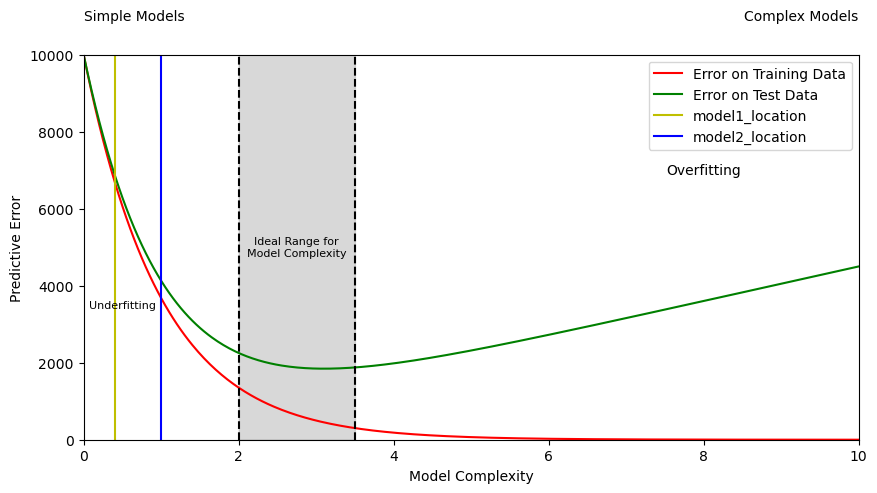

In [42]:
model_complexity = np.linspace(0, 10, 400)

training_error = 10000 * np.exp(-model_complexity) 
test_error = 10000 * np.exp(-model_complexity) + 4500 * (model_complexity / 10)

plt.figure(figsize=(10, 5))

plt.plot(model_complexity, training_error, 'r', label='Error on Training Data')
plt.plot(model_complexity, test_error, 'g', label='Error on Test Data')

plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=3.5, color='k', linestyle='--')
plt.axvline(x=0.4, color='y', label="model1_location")
plt.axvline(x=1.0, color='b', label="model2_location")
plt.fill_betweenx(np.arange(0, 10000), 2, 3.5, color='grey', alpha=0.3)

plt.text(2.75, 5000, 'Ideal Range for\nModel Complexity', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(0.5, 3500, 'Underfitting', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(8, 7000, 'Overfitting', horizontalalignment='center', verticalalignment='center')
plt.text(0, 11000, 'Simple Models', horizontalalignment='left', verticalalignment='center')
plt.text(10, 11000, 'Complex Models', horizontalalignment='right', verticalalignment='center')

plt.xlabel('Model Complexity')
plt.ylabel('Predictive Error')

plt.xlim(0, 10)
plt.ylim(0, 10000)
plt.legend()

plt.show()

In [44]:
!pip install xgboost

  Using cached xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl.metadata (2.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.3 MB/s eta 0:00:00a 0:00:01


In [45]:
from xgboost import XGBRegressor

In [46]:
X_train

,airline,flight_code,class,from,to,time_taken,dep_time,arr_time,num_stops,month,day_of_week,weekend
195919,Vistara,UK_826,economy,Chennai,Bangalore,20.333,13,9,1,3,2,False
192627,Vistara,UK_838,economy,Chennai,Mumbai,16.917,21,14,1,3,0,False
112435,Indigo,6E_6212,economy,Bangalore,Hyderabad,10.000,11,21,1,3,0,False
81668,Vistara,UK_863,economy,Mumbai,Chennai,11.167,9,20,0,3,0,False
35416,Vistara,UK_986,business,Mumbai,Chennai,17.583,23,16,1,2,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...
119879,Indigo,6E_599,economy,Kolkata,Delhi,2.417,11,14,0,2,5,True
52404,Air India,AI_516,business,Bangalore,Chennai,37.750,8,21,0,2,0,False
131932,Vistara,UK_706,economy,Kolkata,Mumbai,8.083,10,18,1,3,3,False
146867,Indigo,6E_2516,economy,Kolkata,Hyderabad,7.000,17,24,1,3,0,False


In [47]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import random
from scipy.stats import randint
pipe = Pipeline([
        ('prepoc', prepoc),
        ('pog', XGBRegressor(n_estimators=150, learning_rate=0.08, max_depth=20, random_state = 42))
    ])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)


RMSE_test = np.sqrt(np.sum((y_test - y_pred)**2) / y_test.shape[0])
RMSE_train = np.sqrt(np.sum((y_train - pipe.predict(X_train))**2) / y_train.shape[0])
print(RMSE_train)
print("Mean Squared Error:", RMSE_test)

3887.619434753402
Mean Squared Error: 4204.3206607103775


In [48]:
random_search.best_params_


{'pog__max_features': 15,
 'pog__min_samples_split': 12,
 'pog__n_estimators': 121}

In [49]:
y_pred = random_search.best_estimator_.predict(X_test)
RMSE_test = np.sqrt(np.sum((y_test - y_pred)**2) / y_test.shape[0])
RMSE_test

4107.34834374879

In [55]:
param_grid = {'pog__n_estimators': [80, 120, 150],
              'pog__learning_rate': [0.2, 0.1, 0.05],
              'pog__max_depth': [5, 7, 15]}

# Initialize the SVM classifier

# Initialize GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prepoc',
                                        ColumnTransformer(transformers=[('airline',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['airline',
                                                                          'class']),
                                                                        ('log',
                                                                         FunctionTransformer(func=<function <lambda> at 0x298006af0>),
                                                                         ['time_taken']),
                                                                        ('test',
                                                                         FunctionTransformer(func=<function <lambda> at 0x298006b80>),
                                           

In [56]:
y_pred = grid_search.best_estimator_.predict(X_test)
RMSE_test = np.sqrt(np.sum((y_test - y_pred)**2) / y_test.shape[0])
print(RMSE_test)
grid_search.best_params_

4187.7343550374


{'pog__learning_rate': 0.1, 'pog__max_depth': 15, 'pog__n_estimators': 120}

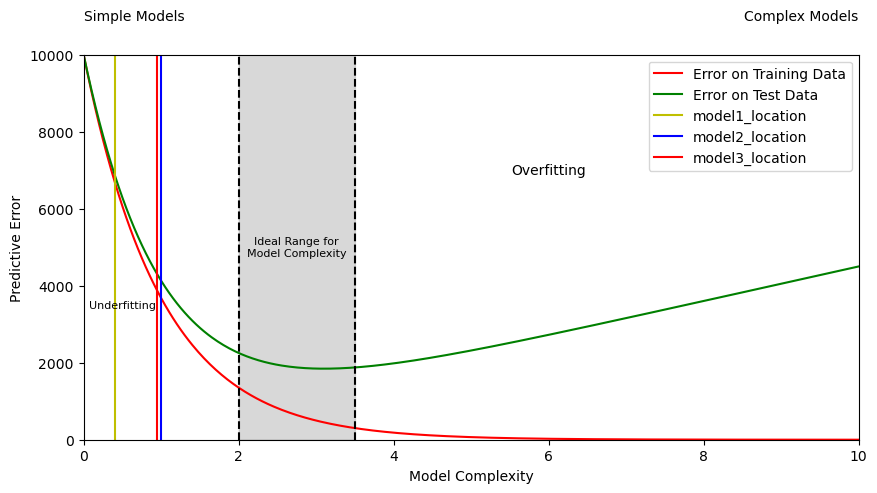

In [58]:
model_complexity = np.linspace(0, 10, 400)

training_error = 10000 * np.exp(-model_complexity) 
test_error = 10000 * np.exp(-model_complexity) + 4500 * (model_complexity / 10)

plt.figure(figsize=(10, 5))

plt.plot(model_complexity, training_error, 'r', label='Error on Training Data')
plt.plot(model_complexity, test_error, 'g', label='Error on Test Data')

plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=3.5, color='k', linestyle='--')
plt.axvline(x=0.4, color='y', label="model1_location")
plt.axvline(x=1.0, color='b', label="model2_location")
plt.axvline(x=0.95, color='r', label="model3_location")
plt.fill_betweenx(np.arange(0, 10000), 2, 3.5, color='grey', alpha=0.3)

plt.text(2.75, 5000, 'Ideal Range for\nModel Complexity', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(0.5, 3500, 'Underfitting', horizontalalignment='center', verticalalignment='center', fontdict={'size': 8})
plt.text(6, 7000, 'Overfitting', horizontalalignment='center', verticalalignment='center')
plt.text(0, 11000, 'Simple Models', horizontalalignment='left', verticalalignment='center')
plt.text(10, 11000, 'Complex Models', horizontalalignment='right', verticalalignment='center')

plt.xlabel('Model Complexity')
plt.ylabel('Predictive Error')

plt.xlim(0, 10)
plt.ylim(0, 10000)
plt.legend()

plt.show()